In [1]:
import numpy as np
import itertools
import h5py
from copy import copy

from scipy import signal, interpolate

import matplotlib.pyplot as plt
from matplotlib import colors
import itertools

import re

from openpyxl import load_workbook

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session

In [2]:
%load_ext autoreload
%autoreload 1
%aimport process_imu

Get data out of HDF5 file.  Convert time to seconds

In [3]:
calibfilename = '/Users/etytel01/Documents/Acceleration/AlgoComparisons/Planar Experiment/calibration.hdf5'

In [4]:
filename = '/Users/etytel01/Documents/Acceleration/AlgoComparisons/Planar Experiment/trial5_015.hdf5'
encoderfilename = '/Users/etytel01/Documents/Acceleration/AlgoComparisons/Planar Experiment/encoder_15.dat'

In [5]:
loadencoder = True
mag = None
with h5py.File(filename, 'r') as h5file:
    if '/data/Mag' in h5file:
        mag = np.array(h5file['/data/Mag'])
    acc = np.array(h5file['/data/Accel'])
    acc2 = np.array(h5file['/data/Accel2'])
    if '/data/Encoder' in h5file:
        enc = np.array(h5file['/data/Encoder'])
        loadencoder = False

    t = np.array(h5file['/data/t'])
t = t/1000.0

if loadencoder:
    enc = np.loadtxt(encoderfilename)

Magnetometer data, if it's in the file

In [6]:
if mag is not None:
    fig, ax = plt.subplots(3,1, sharey=True, sharex=True)
    
    for ax1, mag1, lab1 in zip(ax, np.rollaxis(mag,1), ['X','Y','Z']):
        ax1.plot(t, mag1)
        ax1.set_ylabel(lab1)
    ax[0].set_title('Magnetometer')
    ax[0].set_ylim([-80, 80])
    plt.show()

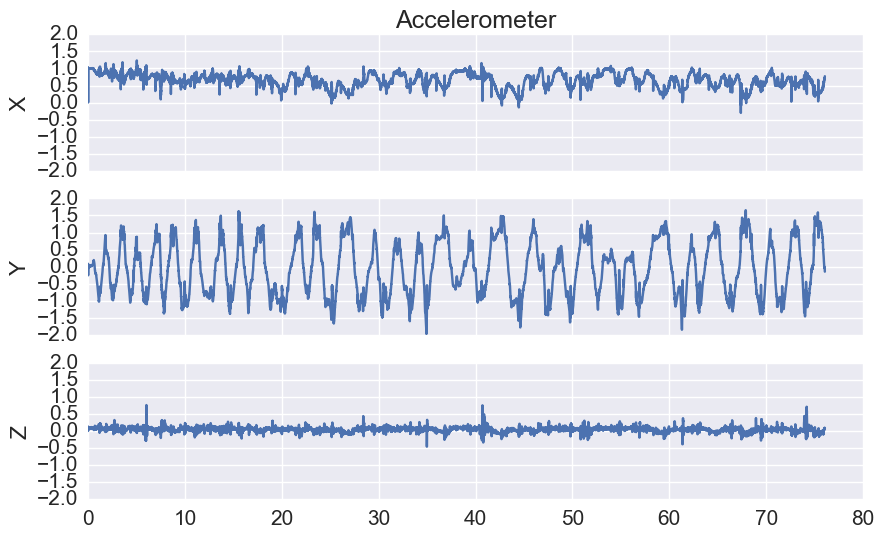

In [7]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=True)

for ax1, acc1, lab1 in zip(ax, np.rollaxis(acc,1), ['X','Y','Z']):
    ax1.plot(t, acc1)
    ax1.set_ylabel(lab1)
ax[0].set_title('Accelerometer')
plt.show()

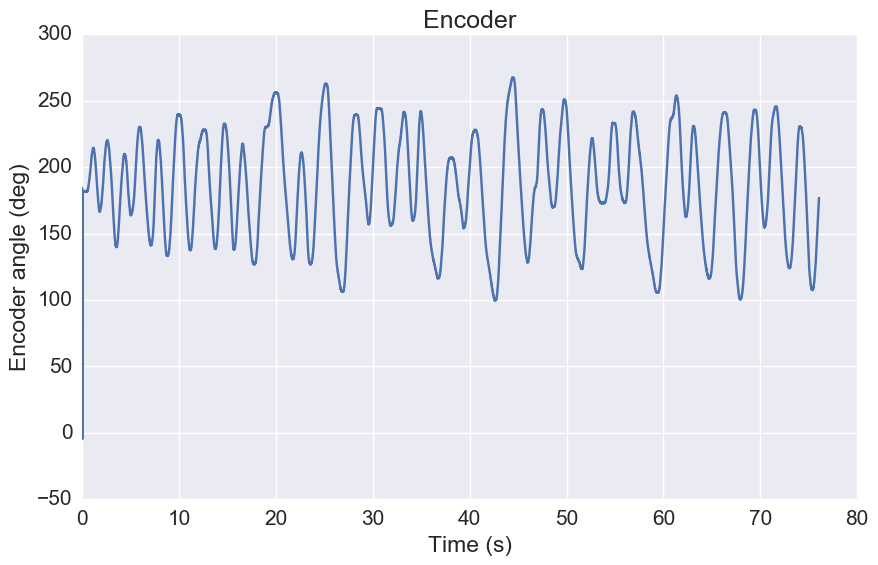

In [9]:
fig, ax = plt.subplots()
ax.plot(t, enc)
ax.set_ylabel('Encoder angle (deg)')
ax.set_xlabel('Time (s)')
ax.set_title('Encoder')
plt.show()

In [25]:
imu = process_imu.IMU()
imu.calibrate(calibfilename)
imu.get_inertial_coords(calibfilename)

In [26]:
imu.load(filename, resamplefreq=200.0)
imu.filter(order=5, gyro_cutoff=[10.0], acc_cutoff=[10.0])

In [27]:
orient_ekf = imu.get_orientation(method='ekf')
accdyn_ekf = imu.accdyn
orient_mad = imu.get_orientation(method='madgwick')
accdyn_mad = imu.accdyn

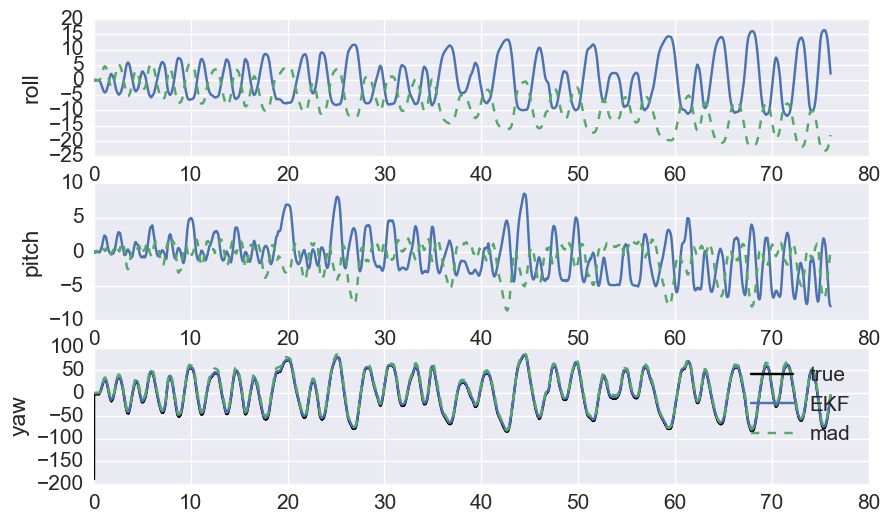

In [30]:
fig, ax = plt.subplots(3,1)
ax[2].plot(t, enc-enc[0], 'k-', label='true')
for ax1, oe, om, lab1 in zip(ax, np.rollaxis(orient_ekf, 1), np.rollaxis(orient_mad, 1), ['roll','pitch','yaw']):
    ax1.plot(imu.t, np.rad2deg(oe), label='EKF')
    ax1.plot(imu.t, np.rad2deg(om-om[0]), '--', label='mad')
    ax1.set_ylabel(lab1)
ax[2].legend()
plt.show()

ValueError: x and y must have same first dimension

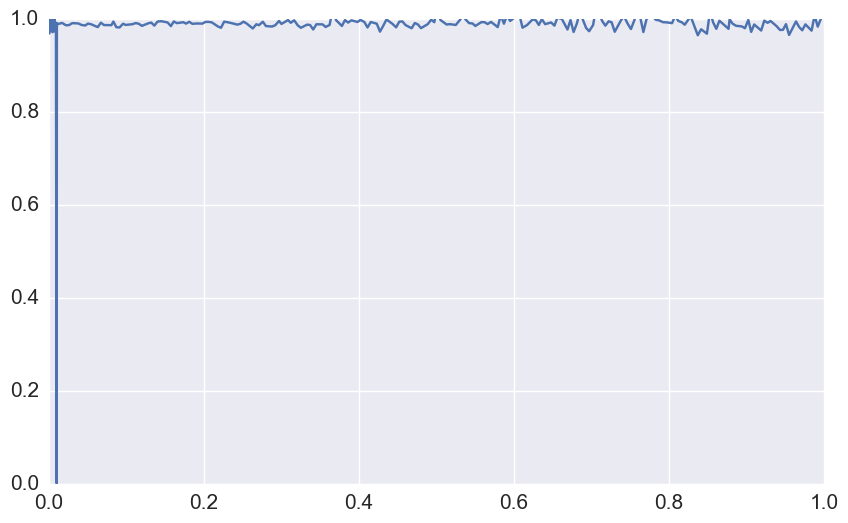

In [22]:
fig, ax = plt.subplots()
ax.plot(t, acc2[:,2], imu.t, accdyn_ekf)